In [277]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob

In [430]:
models = ['GBT', 'LocalMLP', 'LocalLSTM', 'GraphLSTM', 'GraphLSTM_transformed', 'BirdFlowGraphLSTM']
experiments1 = ['_not_transformed', '_not_transformed', '', '', '_root_transformed', '_not_recurrent_force_zeros']
experiments2 = ['_root_transformed', '_root_transformed', '_force_zeros', '_force_zeros', '_root_transformed_force_zeros', '_recurrent']
experiments3 = ['_not_transformed', '_not_transformed', '_force_zeros', '_force_zeros', '_root_transformed_force_zeros', '_recurrent_force_zeros']
results = dict()
base_dir = '/home/fiona/birdMigration/results/radar/testing'
for i, m in enumerate(models):
    #experiment = 'best_config_root_transformed_missing_data' if m == 'GraphLSTM_transformed' else 'best_config' 
    experiment = 'best_config' + experiments3[i]
    model_dir = f'{base_dir}/{m}/{experiment}'
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    print(m, model_dir)
    results[m] = pd.read_csv(files[0])

GBT /home/fiona/birdMigration/results/radar/testing/GBT/best_config_not_transformed
LocalMLP /home/fiona/birdMigration/results/radar/testing/LocalMLP/best_config_not_transformed
LocalLSTM /home/fiona/birdMigration/results/radar/testing/LocalLSTM/best_config_force_zeros
GraphLSTM /home/fiona/birdMigration/results/radar/testing/GraphLSTM/best_config_force_zeros
GraphLSTM_transformed /home/fiona/birdMigration/results/radar/testing/GraphLSTM_transformed/best_config_root_transformed_force_zeros
BirdFlowGraphLSTM /home/fiona/birdMigration/results/radar/testing/BirdFlowGraphLSTM/best_config_recurrent_force_zeros


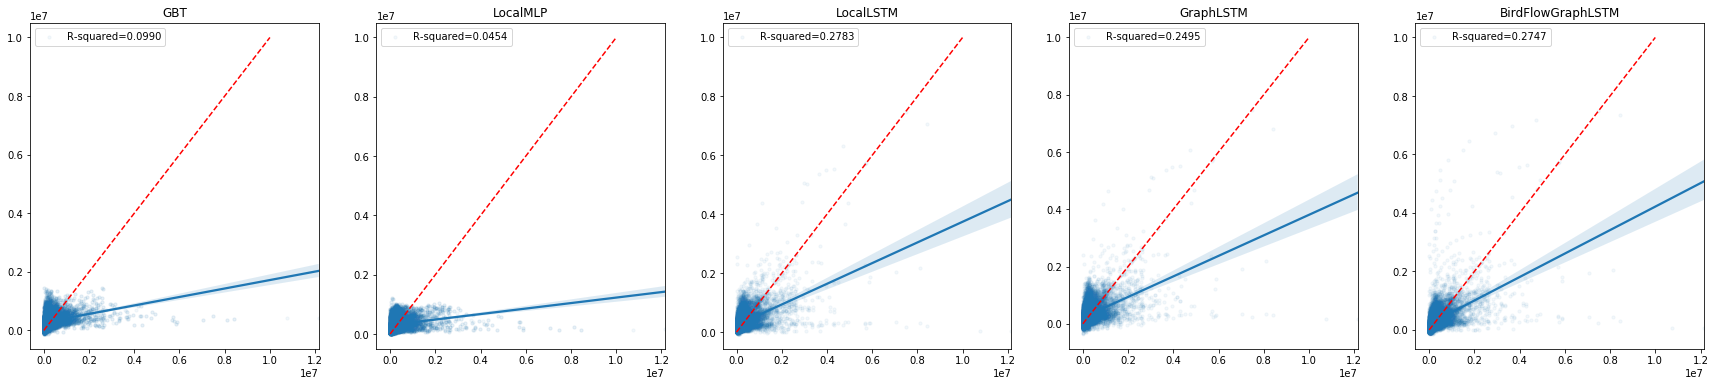

In [294]:
model = 'BirdFlowGraphLSTM'
#model = 'LocalMLP'
#model = 'GBT'

lb = 25
use_log = False

fig, ax = plt.subplots(1, len(models), figsize=(len(models)*6,6))
for midx, m in enumerate(models):
    gt = results[m]['gt'].replace(0, np.nan).values
    mask = np.isfinite(gt) & (gt > lb)
    gt = gt[mask]
    if use_log: gt = np.log(gt)
    
    pred = results[m]['prediction'].replace(0, np.nan).values
    pred = pred[mask]
    if use_log: pred = np.log(np.maximum(pred, lb))
    
    #ax[midx].scatter(gt, pred, alpha=0.05)
    res = sp.stats.linregress(gt, pred)
    sb.regplot(gt, pred, scatter=True, ci=95, ax=ax[midx], label=f'R-squared={res.rvalue**2:.4f}', scatter_kws={'alpha':0.05, 's':10})

    if use_log:
        ax[midx].plot(np.log([lb,1e7]), np.log([lb, 1e7]), ls='--', c='red')
    else:
        ax[midx].plot([lb,1e7], [lb, 1e7], ls='--', c='red')
    #ax[midx].set_xlim(50, 1e7)
    #ax[midx].set_ylim(50, 1e7)
    #ax[midx].set(yscale='symlog', xscale='symlog')
    ax[midx].legend()
    ax[midx].set_title(m)

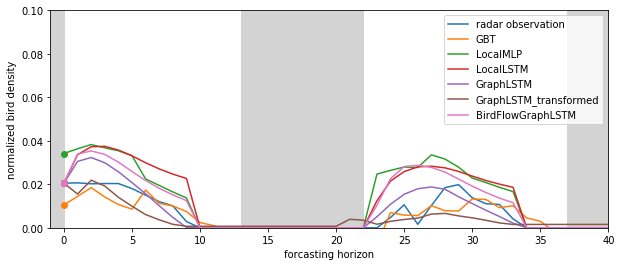

In [431]:
sid = 8
radar = 'deoft'
trial = 0

fig, ax = plt.subplots(figsize=(10, 4))
for i, m in enumerate(models):
    r = results[m].query(f'seqID == {sid} & radar == "{radar}" & trial == {trial}')
    if i==0:
        ax.plot(range(len(r)), r['gt']/bird_scale, label='radar observation')
    line = ax.plot(range(len(r)), r['prediction']/bird_scale, label=m)
    ax.plot(0, r['prediction'].iloc[0]/bird_scale, 'o', c=line[0].get_color())
    
ax.fill_between(range(13, 23), 0, 0.1, color='lightgray')
ax.fill_between(range(-1, 1), 0, 0.1, color='lightgray')
ax.fill_between(range(37, 41), 0, 0.1, color='lightgray')
ax.set(ylim=(0, 0.1), xlim=(-1, 40), xlabel='forcasting horizon', ylabel='normalized bird density')
plt.legend()
#fig.savefig('/home/fiona/birdMigration/data/plots/presentations/example_forecast.png', bbox_inches='tight', dpi=300)

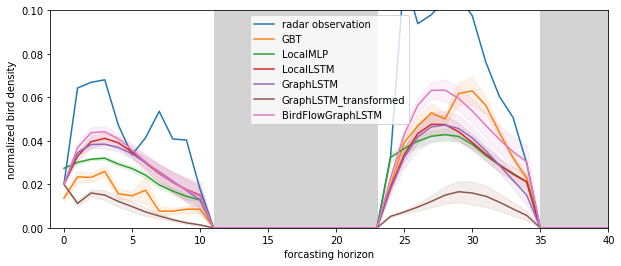

In [454]:
sid = 22
radar = 'deoft'
trial = 0

fig, ax = plt.subplots(figsize=(10, 4))
for i, m in enumerate(models):
    r = results[m].query(f'seqID == {sid} & radar == "{radar}"')
    if i==0:
        r0 = r.query(f'trial == 0')
        ax.plot(range(len(r0)), r0['gt']/bird_scale, label='radar observation')
        
    all_trials = []
    for trial in r.trial.unique():
        r_t = r.query(f'trial == {trial}')
        all_trials.append(r_t['prediction']/bird_scale * r_t['night'])
    all_trials = np.stack(all_trials, axis=0)

    line = ax.plot(range(all_trials.shape[1]), all_trials.mean(0), label=m)
    ax.fill_between(range(all_trials.shape[1]), all_trials.mean(0)-all_trials.std(0), all_trials.mean(0)+all_trials.std(0), color=line[0].get_color(), alpha=0.1)
    #ax.plot(0, r['prediction'].iloc[0]/bird_scale, 'o', c=line[0].get_color())
    
#ax.fill_between(range(13, 23), 0, 0.1, color='lightgray')
#ax.fill_between(range(-1, 1), 0, 0.1, color='lightgray')
#ax.fill_between(range(37, 41), 0, 0.1, color='lightgray')
end_night = np.concatenate([np.where(r0['night'].iloc[1:].values & ~r0['night'].iloc[:-1].values)[0], [len(r0)]])
start_night = np.where(r0['night'].iloc[:-1].values & ~r0['night'].iloc[1:].values)[0]
for i, tidx in enumerate(start_night):
    ax.fill_between([tidx + 1, end_night[i]], 0, 0.1, color='lightgray')
ax.set(ylim=(0, 0.1), xlim=(-1, 40), xlabel='forcasting horizon', ylabel='normalized bird density')
plt.legend()


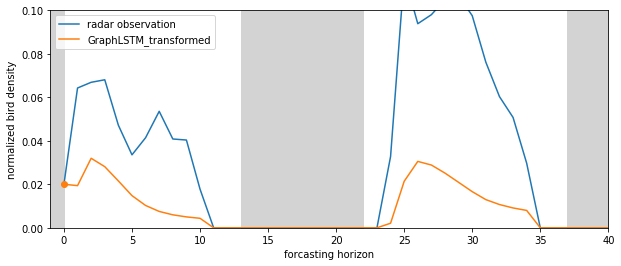

In [407]:
sid = 22
radar = 'deoft'
trial = 0

fig, ax = plt.subplots(figsize=(10, 4))
for i, m in enumerate(['GraphLSTM_transformed']):
    r = results[m].query(f'seqID == {sid} & radar == "{radar}" & trial == {trial}')
    if i==0:
        ax.plot(range(len(r)), r['gt']/bird_scale, label='radar observation')
    line = ax.plot(range(len(r)), r['prediction']/bird_scale * r['night'], label=m)
    ax.plot(0, r['prediction'].iloc[0]/bird_scale, 'o', c=line[0].get_color())
    
ax.fill_between(range(13, 23), 0, 0.1, color='lightgray')
ax.fill_between(range(-1, 1), 0, 0.1, color='lightgray')
ax.fill_between(range(37, 41), 0, 0.1, color='lightgray')
ax.set(ylim=(0, 0.1), xlim=(-1, 40), xlabel='forcasting horizon', ylabel='normalized bird density')
plt.legend()

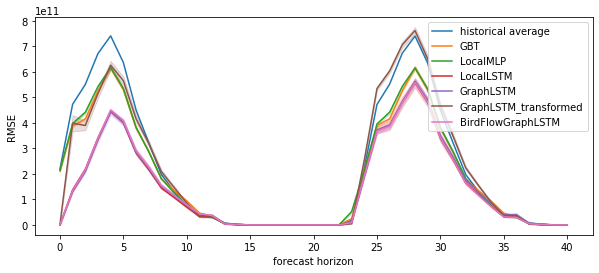

In [434]:
fig, ax = plt.subplots(figsize=(10, 4))

def compute_mse(row, bird_scale=1):
    if row['missing']:
        return np.nan
    else:
        return ((row['gt'] - row['prediction'] * row['night'])/bird_scale)**2

for idx, m in enumerate(models):
    if idx == 0:
        constant_prediction = results[m].groupby('radar')['gt'].aggregate(np.mean)
        results[m]['constant_error'] = results[m].apply(lambda row: (row['gt'] - constant_prediction.loc[row.radar] * row.night)**2, axis=1)
        mse_const = results[m].groupby(['horizon', 'trial']).constant_error.mean() #.apply(np.sqrt)
        mean_mse_c = mse_const.groupby('horizon').aggregate(np.mean)
        ax.plot(mean_mse_c, label='historical average')
    
    results[m]['error'] = results[m].apply(lambda row: compute_mse(row), axis=1)
    mse = results[m].groupby(['horizon', 'trial']).error.mean() #.apply(np.sqrt)
    mean_mse = mse.groupby('horizon').aggregate(np.mean)
    std_mse = mse.groupby('horizon').aggregate(np.std)
    
    l = ax.plot(mean_mse, label=m)
    ax.fill_between(mean_mse.index, mean_mse+std_mse, mean_mse-std_mse, alpha=0.2, color=l[0].get_color())
    
plt.legend()
ax.set(xlabel='forecast horizon', ylabel='RMSE');

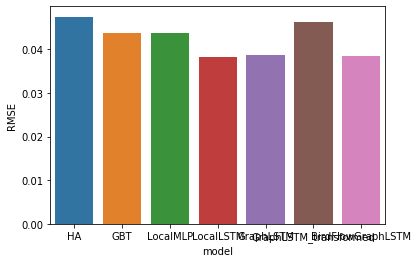

In [433]:
fig, ax = plt.subplots()
rmse_list = []
labels = []
bird_scale = 9938497.9440479
for idx, m in enumerate(models):
    if idx == 0:
        constant_prediction = results[m].groupby('radar')['gt'].aggregate(np.mean)
        results[m]['constant_error'] = results[m].apply(lambda row: ((row['gt'] - constant_prediction.loc[row.radar] * row.night)/bird_scale)**2, axis=1)
        mse_const = np.sqrt(results[m].constant_error.mean())
        rmse_list.append(mse_const)
        labels.append('HA')
    
    rmse_list.append(np.sqrt(results[m].apply(lambda row: ((row['gt'] - row['prediction'] * row.night)/bird_scale)**2, axis=1).mean()))
    labels.append(m)
    
df = pd.DataFrame(dict(RMSE=rmse_list, model=labels))
sb.barplot(x='model', y='RMSE', data=df)
ax.set(ylabel='RMSE');

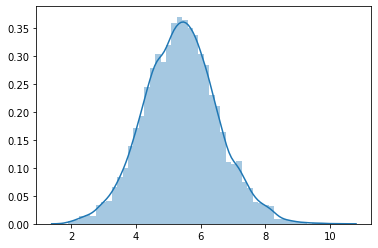

In [302]:
sb.distplot(np.power(gt, 1/7))

In [381]:
df = pd.read_csv('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/dynamic_features.csv')

In [305]:
df.columns

Index(['Unnamed: 0', 'birds', 'birds_from_buffer', 'radar', 'solarpos_dt',
       'solarpos', 'night', 'dusk', 'dawn', 'datetime', 'dayofyear', 'tidx',
       'u', 'v', 'cc', 'tp', 'sp', 't2m', 'sshf', 'wind_speed', 'wind_dir',
       'nightID', 'acc_rain', 'acc_wind', 'wind_profit'],
      dtype='object')

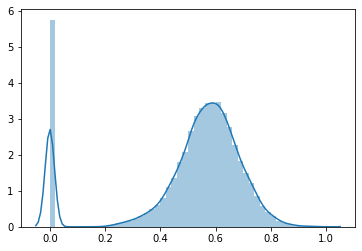

In [361]:
col = 'birds'
data = np.power(df[col][df.night].values, 1/7.5)
data_scaled = data / np.nanmax(data)
sb.distplot(data_scaled)
#sb.distplot(np.log(df[col].values + 0.0001))
#sb.distplot(df[col][df[col]>0].values)
#np.nanmax(np.power(df[col][df.night].values, 1/7))

In [338]:
np.power(0, 1/5)

0.0

(-6.123561718243683e-18, 1.0)

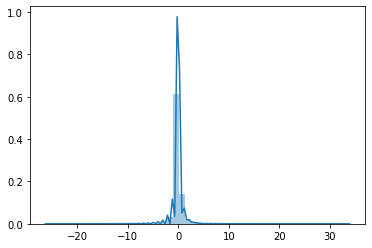

In [351]:
diff = df['birds'][df.night].values[1:] - df['birds'][df.night].values[:-1]
#sb.distplot(diff)
m = np.nanmean(diff)
s = np.nanstd(diff)
diff_s = (diff-m)/s
sb.distplot(diff_s)
np.nanmean(diff_s), np.nanstd(diff_s)

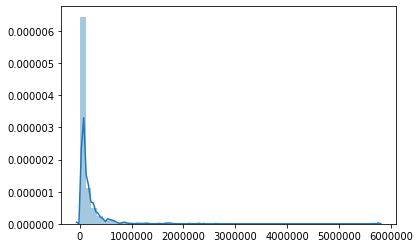

In [349]:
sb.distplot(df['birds'].values[1:][df.night.values[1:] & ~df.night.values[:-1]])

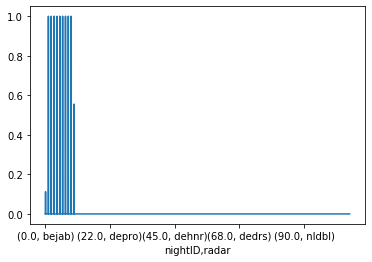

In [383]:
df['missing'] = df.birds.isna()
df.groupby(['nightID', 'radar']).missing.aggregate(np.mean).plot()
#df.groupby(['nightID']).missing.aggregate(np.mean).plot()

In [370]:
a = np.array([1,2, np.nan])
b = torch.tensor(a)

In [371]:
b

tensor([1., 2., nan], dtype=torch.float64)

In [384]:
a = np.ones((3,3,3))
a.mean((0,1))

array([1., 1., 1.])